# 🌲🔥 **California Wildfire Damage** 🔥🌲


## **Introduction**

<span style="font-size: 20px;">California's dry climate and frequent droughts create a perfect condition for wildfire. These wildfires can spread rapidly and have the possibility of causing great damages: destroyging houses, businesses, vehicles, and even taking lives. Beyond the immediate destruction, wildfire also leads to economic loss and environmental harm. Because of their devastating impact, it is extremely important to understand more about them and be able to anticipate when, where wildfires would happen as well as the magnitude of the fire. This project focuses on classifying what California's counties would be more likely to experience a severe wildfires.</span>

<span style="font-size: 20px;">To classify the counties into whether they would have a high risk of having catastrophic wildfires versus low risk, we utilize the public dataset California Wildfire Damage that is available on Kaggle. This dataset provides a complete record of wildfire incidents that happened in California over the past 10 years. It consists of a lot of crucial variables that are highly needed for this project: Date, Location, Area affected by wildfires, Homes destroyed, Businesses destroyed, Vehicles damaged, Injuries, Fatalities, Financial Loss, and Cause.</span>

## Import libraries

In [25]:
# Importing datasets
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import kagglehub
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import os
import geopandas as gpd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

## Import dataset

<span style="font-size: 20px;">For this project, we will use 2 datasets:</span>

| Dataset                              | Description                                    | Key Features                                                                                                    |
| ------------------------------------ | ---------------------------------------------- | --------------------------------------------------------------------------------------------------------------- |
| **California\_Wildfire\_Damage.csv** | Records of wildfires in California (2014–2024) | County, Acres Burned, Homes/Businesses Destroyed, Vehicles Damaged, Injuries, Fatalities, Financial Loss, Cause |
| **CA\_Counties.shp**                 | Geospatial shapefile of California counties    | County boundaries for mapping and spatial analysis                                                              |


In [26]:
df = pd.read_csv("../data/California Wildfire Damage.csv")
Counties = gpd.read_file("../data/archive (1)")

## **Exploratory Data Analysis**

In [27]:
print(df.shape)
print(df.info())
print(df.describe())
print(df.isnull().sum())

(100, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Incident_ID                           100 non-null    object 
 1   Date                                  100 non-null    object 
 2   Location                              100 non-null    object 
 3   Area_Burned (Acres)                   100 non-null    int64  
 4   Homes_Destroyed                       100 non-null    int64  
 5   Businesses_Destroyed                  100 non-null    int64  
 6   Vehicles_Damaged                      100 non-null    int64  
 7   Injuries                              100 non-null    int64  
 8   Fatalities                            100 non-null    int64  
 9   Estimated_Financial_Loss (Million $)  100 non-null    float64
 10  Cause                                 100 non-null    object 
dtypes: float64

In [28]:
# Renaming the variables
dic = {"Area_Burned (Acres)":"Area_Burned", "Estimated_Financial_Loss (Million $)": "Financial_Loss"}
df = df.rename(columns = dic)
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

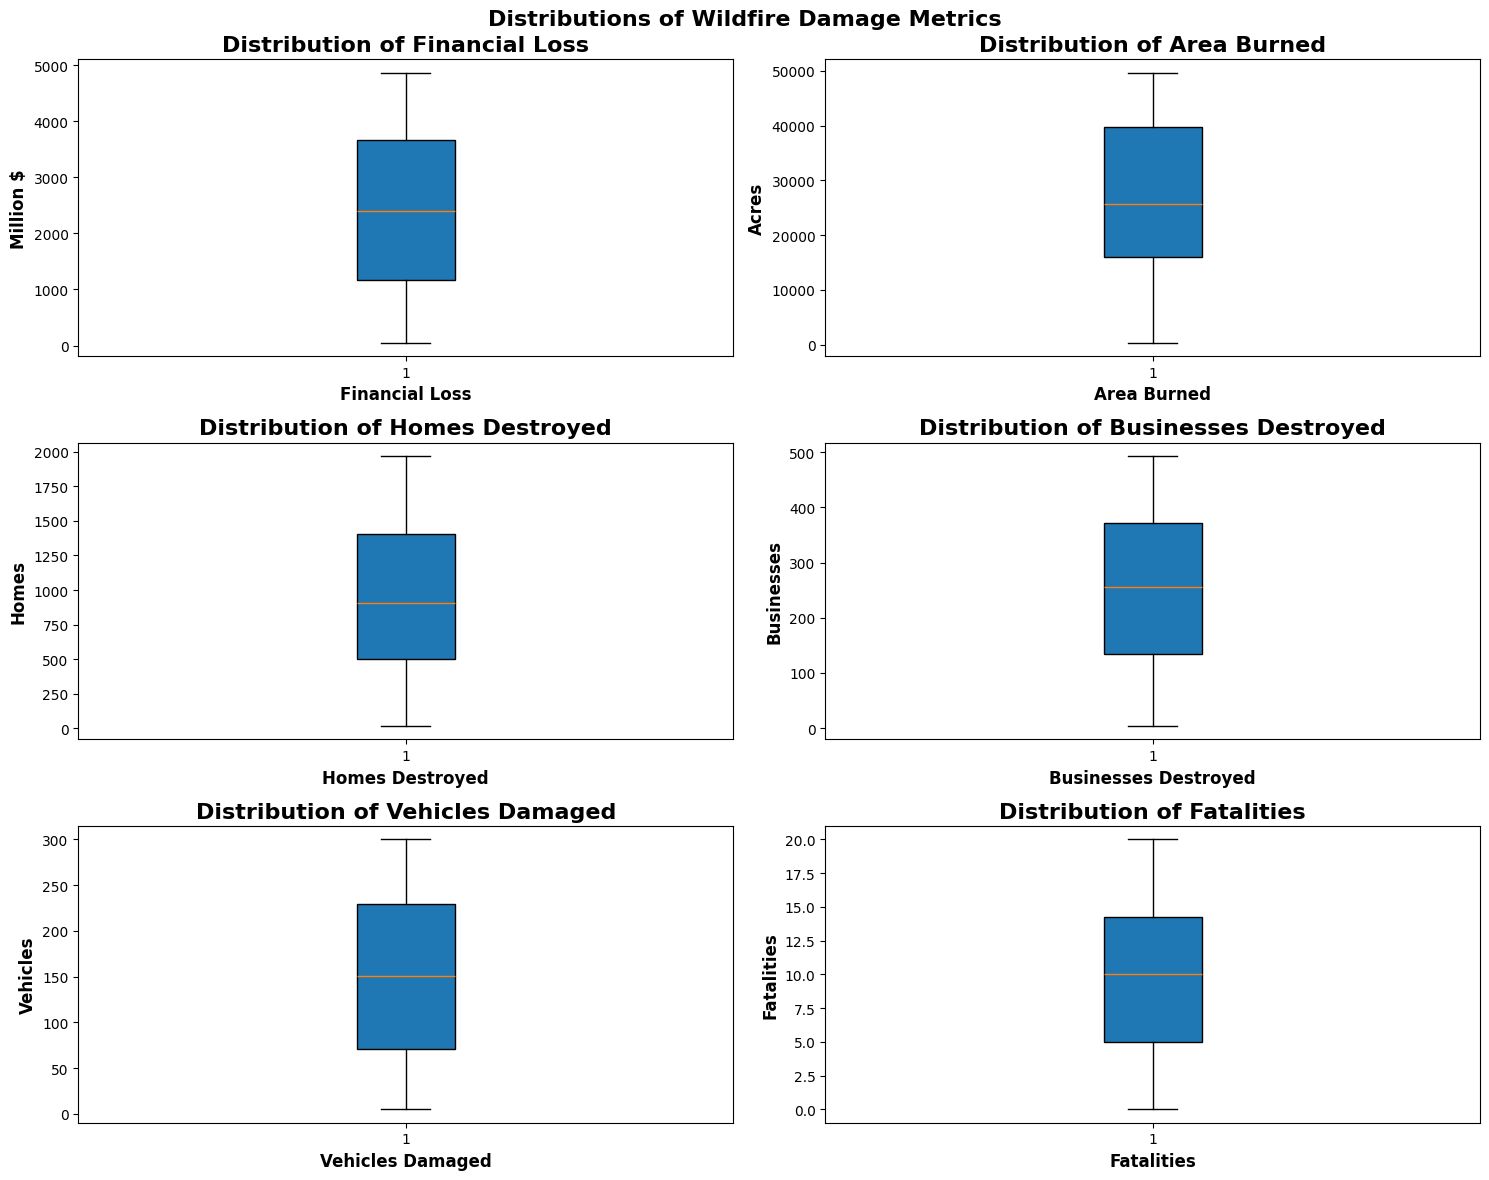

In [29]:
# Visualize the distribution of the variables
cols = ["Financial_Loss", "Area_Burned", "Homes_Destroyed", 
        "Businesses_Destroyed", "Vehicles_Damaged", "Fatalities"]
y_labels = ["Million $", "Acres", "Homes",
            "Businesses", "Vehicles", "Fatalities"]
fig, ax = plt.subplots(3, 2, figsize=(15, 12))
ax = ax.flatten()

for i, col in enumerate(cols):
    ax[i].boxplot(df[col].dropna(), vert = True, patch_artist = True)
    ax[i].set_title(f"Distribution of {col.replace('_',' ')}", fontsize=16, weight="bold")
    ax[i].set_xlabel(col.replace('_',' '), fontsize = 12, weight = "bold")
    ax[i].set_ylabel(y_labels[i], fontsize = 12, weight = "bold")

plt.suptitle("Distributions of Wildfire Damage Metrics", fontsize=16, weight="bold")
plt.tight_layout()
plt.show()

<span style="font-size: 20px;">Overall, we see that all the variables (Financial Loss, Area Burned, Homes Destroyed, Businesses Destroyed, Vehicles Damaged, Fatalities) are approximately normally distributed. That means we can apply clustering without data transformation.</span>

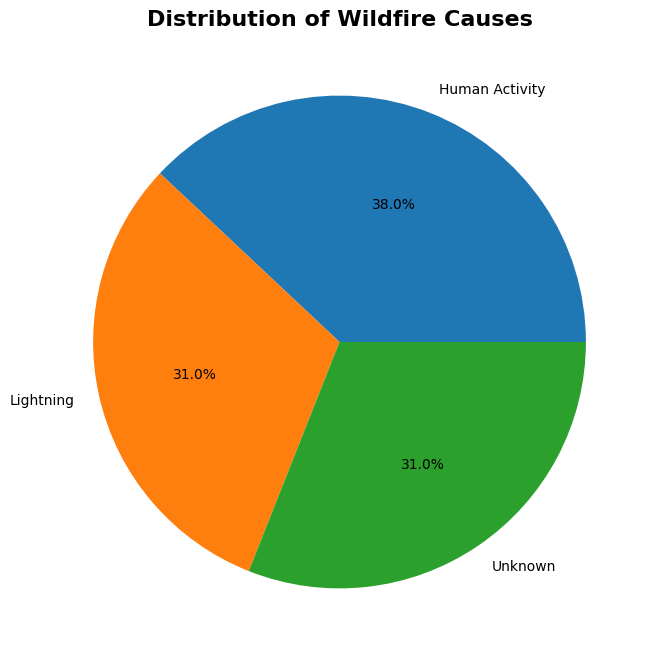

In [30]:
# Visualize the percentage of Cause
cause_counts = df.groupby('Cause').agg(count=('Date', 'count')).reset_index()
plt.figure(figsize = (12,8))
plt.pie(cause_counts['count'], labels=cause_counts['Cause'], autopct='%1.1f%%')
plt.title("Distribution of Wildfire Causes", fontsize = 16, weight = 'bold')
plt.show()

<span style="font-size: 20px;">We see that the distribution for causes are approximately equal. The highest percentage of cost is Human Activity. This includes arson, burning debris, etc. Coming in second are Lightning and Unknown causes. One way that we can prevent more wildfires is to raise public awareness about activities that can cause fire.</span>

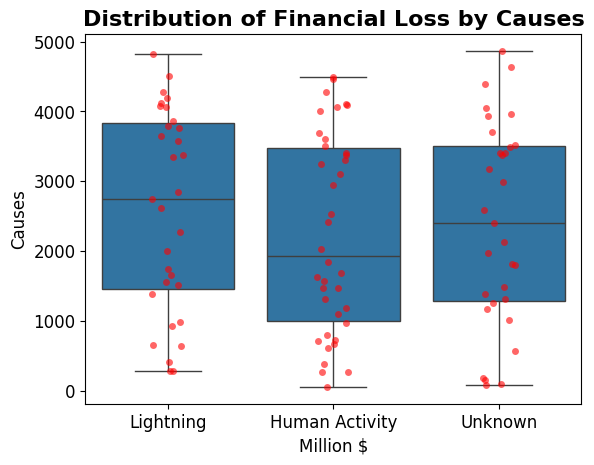

In [31]:
# Visualize the damage of each cost
sns.boxplot(x="Cause", y="Financial_Loss", data=df)
sns.stripplot(x="Cause", y="Financial_Loss", data=df, 
               color="red", alpha=0.6)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel("Million $", fontsize = 12)
plt.ylabel("Causes", fontsize = 12)
plt.title("Distribution of Financial Loss by Causes", fontsize = 16, weight = "bold")
plt.show()

<span style="font-size: 20px;">One important things that we notice on this graph is that despite causing the most wildfires, Human Activity Cause has a lower min, median, and max Financial Damage. On the other hand, Lightning's distribution of Financial Loss seems to be a little bit higher than the other 2. This might be explained that Human Activity has a smaller magnitude than Lightning, therefore creates less financial damage.</span>

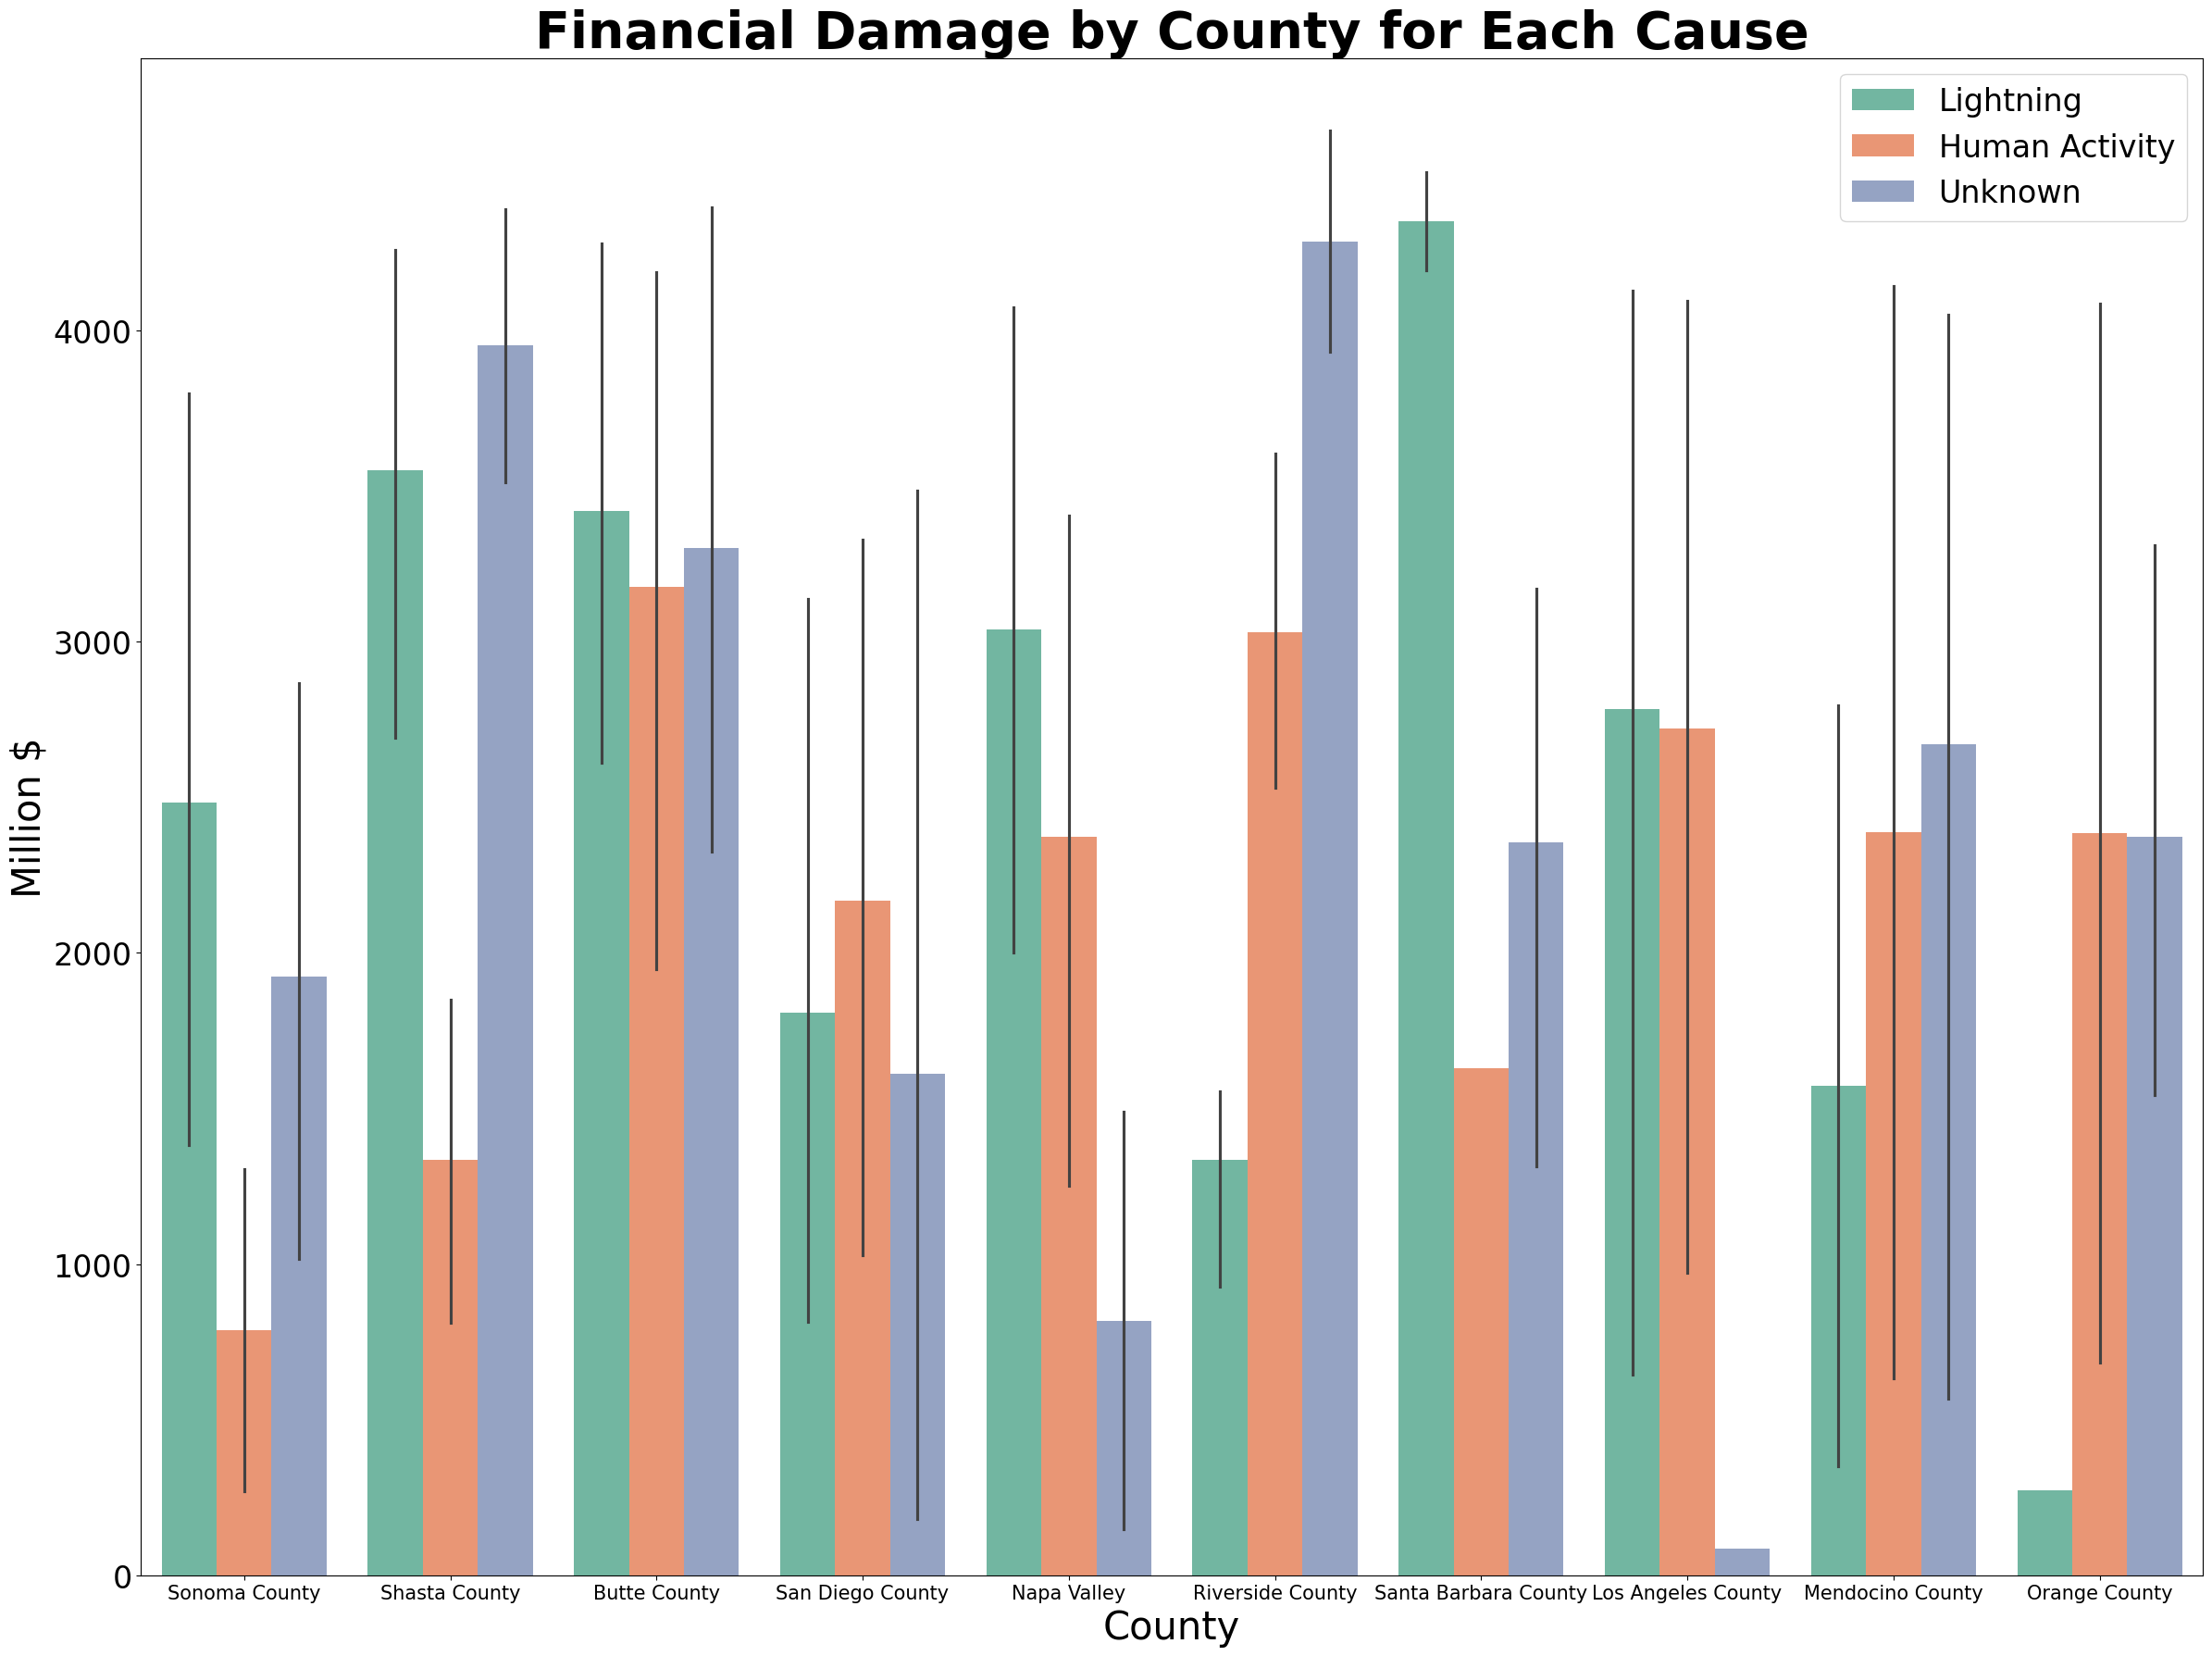

In [32]:
plt.figure(figsize = (24,18))
sns.barplot(x = 'Location', y = 'Financial_Loss', data = df, hue = 'Cause', palette = 'Set2')
plt.xlabel("County", fontsize = 30)
plt.ylabel("Million $", fontsize = 30)
plt.title("Financial Damage by County for Each Cause", fontsize = 40, weight = 'bold')
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 24)
plt.legend(fontsize = 24)
plt.tight_layout()
plt.show()

<span style="font-size: 20px;">Highest damages is reported in Santa Barbara and Riverside, both experiencing more than 4000 Million $ loss by 1 cause. We see that Lightning and Unknown activites are the one that causes the higher damage than Human Activity in the majority of counties. However, there are a few counties where Human Activity caused the highest damages.</span>

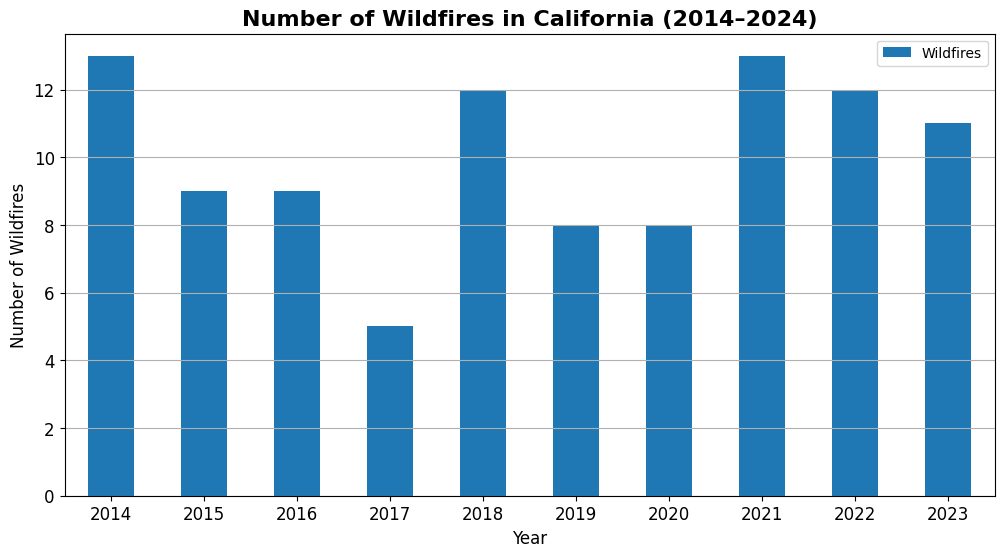

In [33]:
# Number of wildfires by Year
df.groupby('Year').agg(Wildfires = ('Date', 'count')).plot(kind = 'bar', figsize = (12,6))
plt.xticks(rotation = 0, fontsize = 12)
plt.yticks(fontsize = 12)
plt.title("Number of Wildfires in California (2014–2024)", fontsize=16, weight="bold")
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of Wildfires", fontsize=12)
plt.grid(axis = "y")
plt.show()

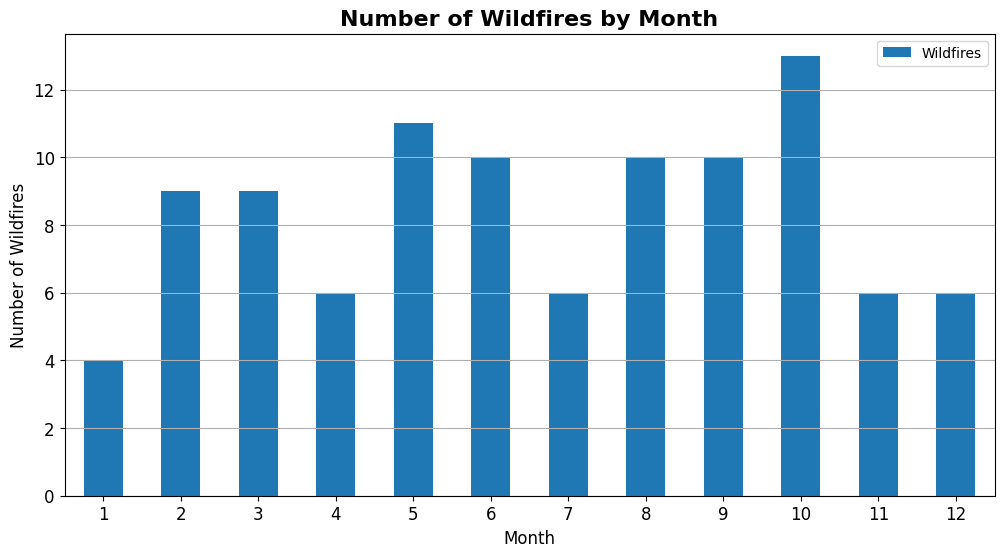

In [34]:
# Number of wildfires by Month
df.groupby('Month').agg(Wildfires = ('Date', 'count')).plot(kind = 'bar', figsize = (12,6))
plt.xticks(rotation = 0, fontsize = 12)
plt.yticks(fontsize = 12)
plt.title("Number of Wildfires by Month", fontsize=16, weight="bold")
plt.xlabel("Month", fontsize=12)
plt.ylabel("Number of Wildfires", fontsize=12)
plt.grid(axis = "y")
plt.show()

<span style="font-size: 20px;">Throughout 10 years, we see that the number of wildfires fluctuates and peaks in 2014, 2018, and 2021. This shows no trend at all. However, for the Month graphs, we see that the months with highest wildfires are May, June, August, September, October. This aligns with the Summer and Fall season with the exception of July. This phenomennon indicates that the dry and windy climate creates more wildfires. For that reason, we should be careful with wildfires during the dry season.</span>


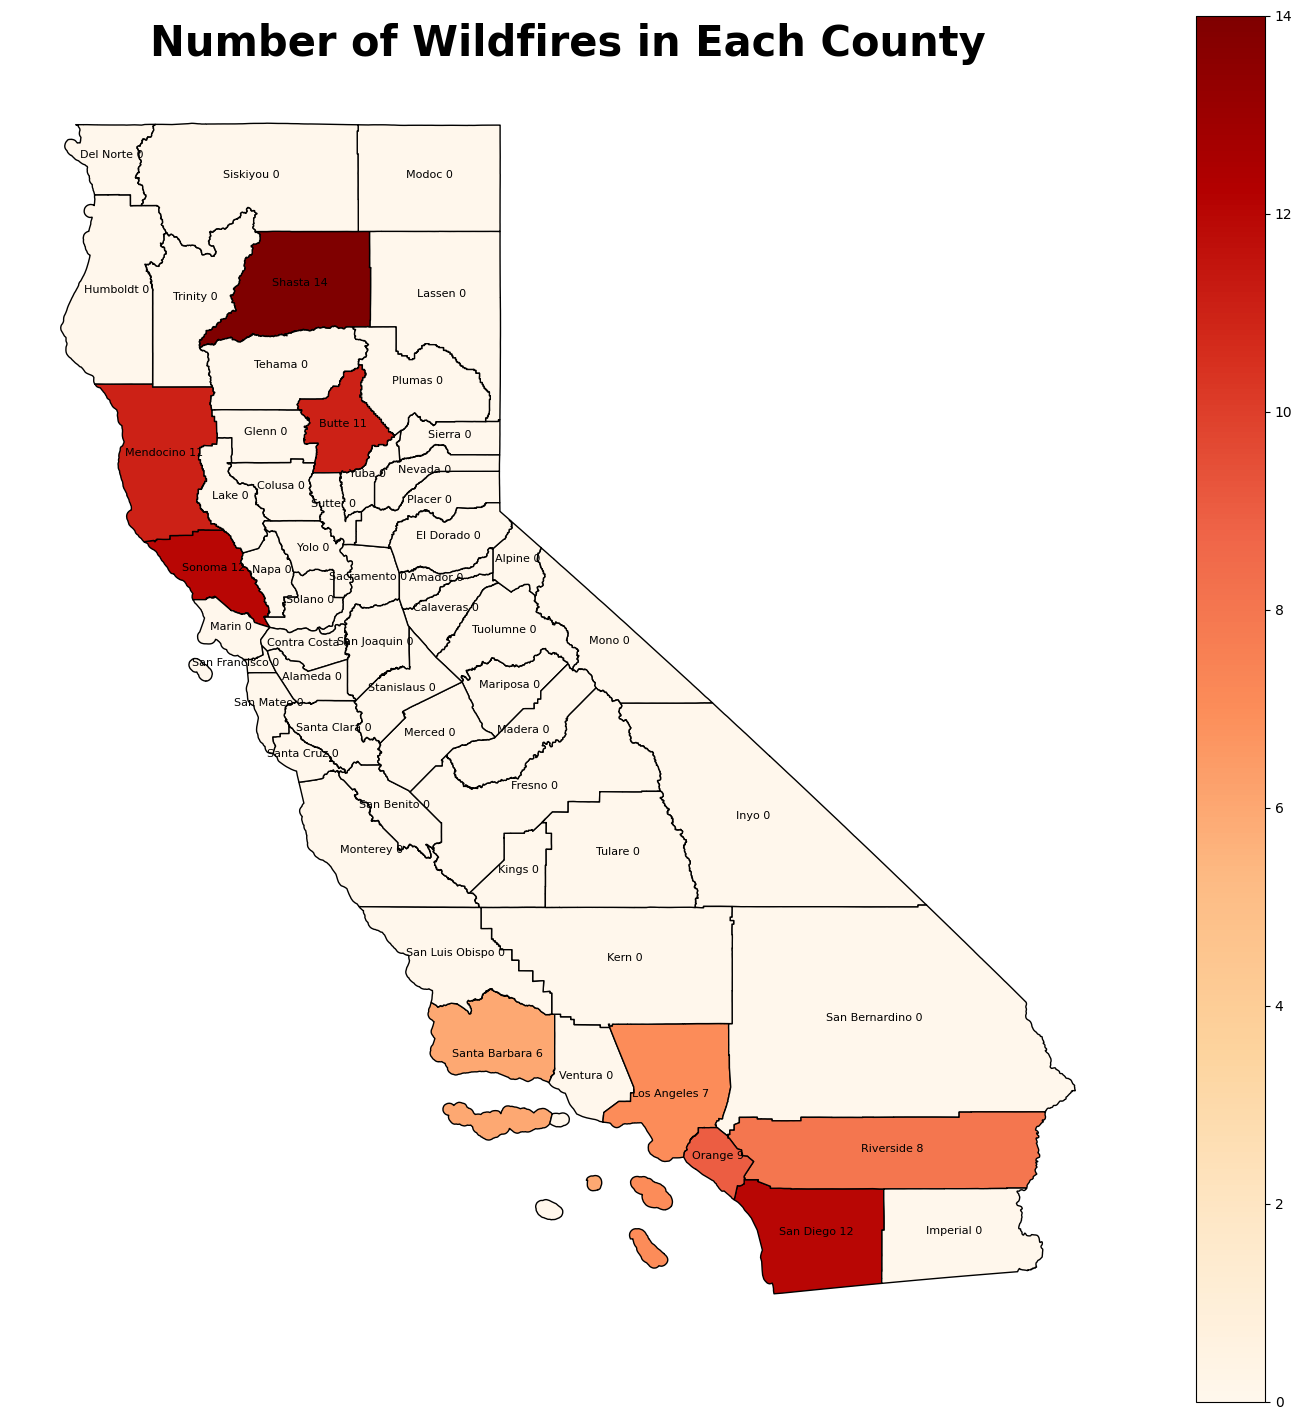

In [35]:
# Number of wildfire incidents happened in each county during the period 2014 - 2023
wildfire_counts = df.groupby('Location').agg(Wildfire_Count = ('Date', 'count'))
Counties_count = Counties.merge(wildfire_counts, left_on = 'NAMELSAD', right_on = 'Location', how = "left")
Counties_count['Wildfire_Count'] = Counties_count['Wildfire_Count'].fillna(0)

fig,ax = plt.subplots(figsize = (18,18))
Counties_count.plot(column="Wildfire_Count",
                cmap = 'OrRd',
                legend= True,
                edgecolor= 'black',
                ax = ax)

for idx, row in Counties_count.iterrows():
    plt.annotate(
        text=f"{row['NAME']} {int(row['Wildfire_Count'])}",
        xy=(row["geometry"].centroid.x, row["geometry"].centroid.y),
        ha="center", fontsize=8, color="black"
    )

plt.title("Number of Wildfires in Each County", fontsize = 30, weight = 'bold')
plt.axis("off")
plt.savefig("../outputs/figures/wildfires.png", dpi=300, bbox_inches="tight")
plt.show()

<span style="font-size: 20px;">In this map, we aggregate the totla number of wildfires that happened in each county in during 2014-2023 period. We see from this map that the number of wildfires are not equally distributed. The county with the highest number of wildfires is Shasta County, having 14 incidents, while the the lowest is Santa Barbara with 6 wildfires. Some of the counties are at a higher risk of experiencing wildfires are Shasta (14), Sonoma (12), San Diego (12), Mendocino (11), Butte (11).</span>

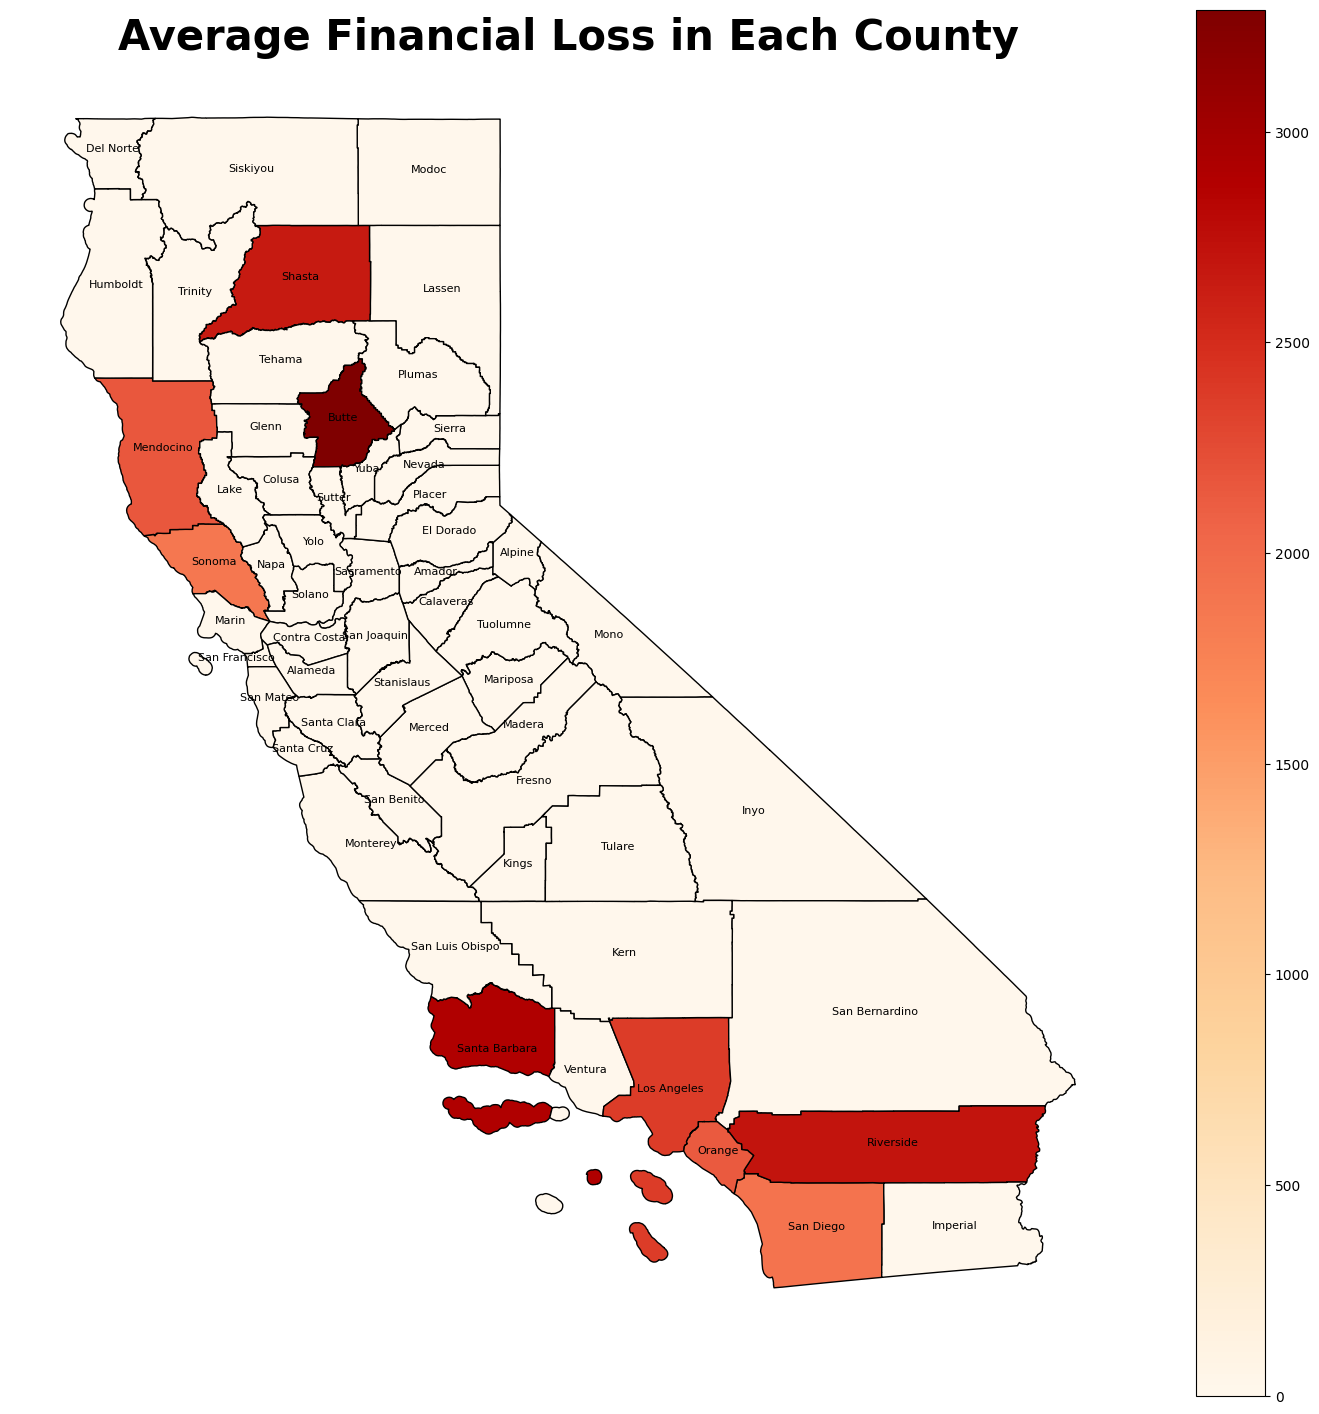

In [36]:

wildfire_damage = df.groupby('Location').agg(Wildfire_Damage = ('Financial_Loss', 'mean'))
Counties_damage = Counties.merge(wildfire_damage, left_on = 'NAMELSAD', right_on = 'Location', how = "left")
Counties_damage['Wildfire_Damage'] = Counties_damage['Wildfire_Damage'].fillna(0)

fig,ax = plt.subplots(figsize = (18,18))
Counties_damage.plot(column="Wildfire_Damage",
                cmap = 'OrRd',
                legend= True,
                edgecolor= 'black',
                ax = ax)
for idx, row in Counties_damage.iterrows():
    plt.annotate(
        text= row['NAME'],
        xy=(row["geometry"].centroid.x, row["geometry"].centroid.y),
        ha="center", fontsize=8, color="black"
    )

plt.title("Average Financial Loss in Each County", fontsize = 30, weight = 'bold')
plt.axis("off")
plt.show()

<span style="font-size: 20px;">We see that Riverside, Santa Barbara, and Butte are the counties that have the highest financial loss. Combined with the information in the first graph, we see that Butte County often has severe wildfire. Riverside and Santa Barbara experience less severe wildfires. San Diego, Mendocino, and Sonoma have more wildfires but less average financial loss, meaning that their fires happened more frequent but not strong.</span>

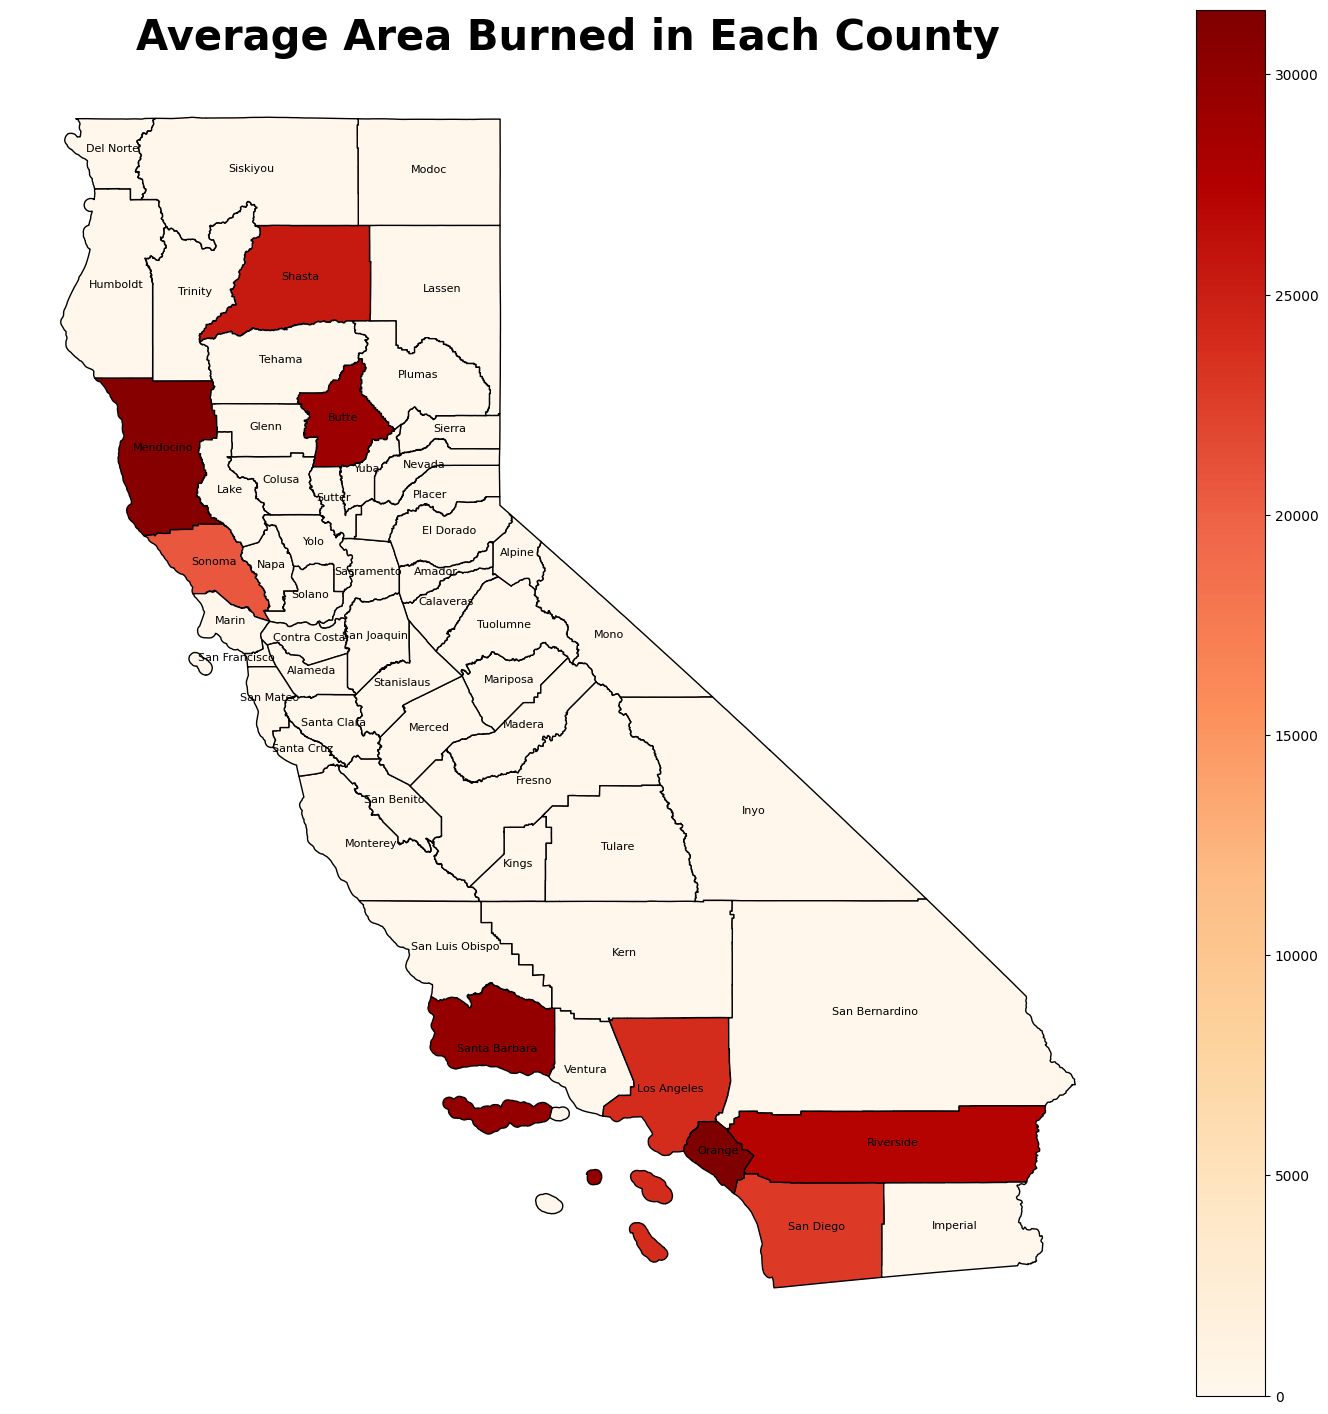

In [37]:
area_burned = df.groupby('Location').agg(Area = ('Area_Burned','mean'))
Counties_area = Counties.merge(area_burned, left_on = 'NAMELSAD', right_on = 'Location', how = "left")
Counties_area['Area'] = Counties_area['Area'].fillna(0)

fig,ax = plt.subplots(figsize = (18,18))
Counties_area.plot(column="Area",
                cmap = 'OrRd',
                legend= True,
                edgecolor= 'black',
                ax = ax)

for idx, row in Counties_area.iterrows():
    plt.annotate(
        text= row['NAME'],
        xy=(row["geometry"].centroid.x, row["geometry"].centroid.y),
        ha="center", fontsize=8, color="black"
    )

plt.title("Average Area Burned in Each County", fontsize = 30, weight = 'bold')
plt.axis("off")
plt.show()

<span style="font-size: 20px;">This map demononstrated the average acres burned in each county. One interesting thing we notice here is Santa Barbara, Butte, and Orange all have a small area but have a very large average area burned. Moreover, all these counties except Butte have relatively low number of wildfires for the past decade. This suggests that even though Santa Barbara and Orange have less fires, theirs tend to be more widespread.</span>

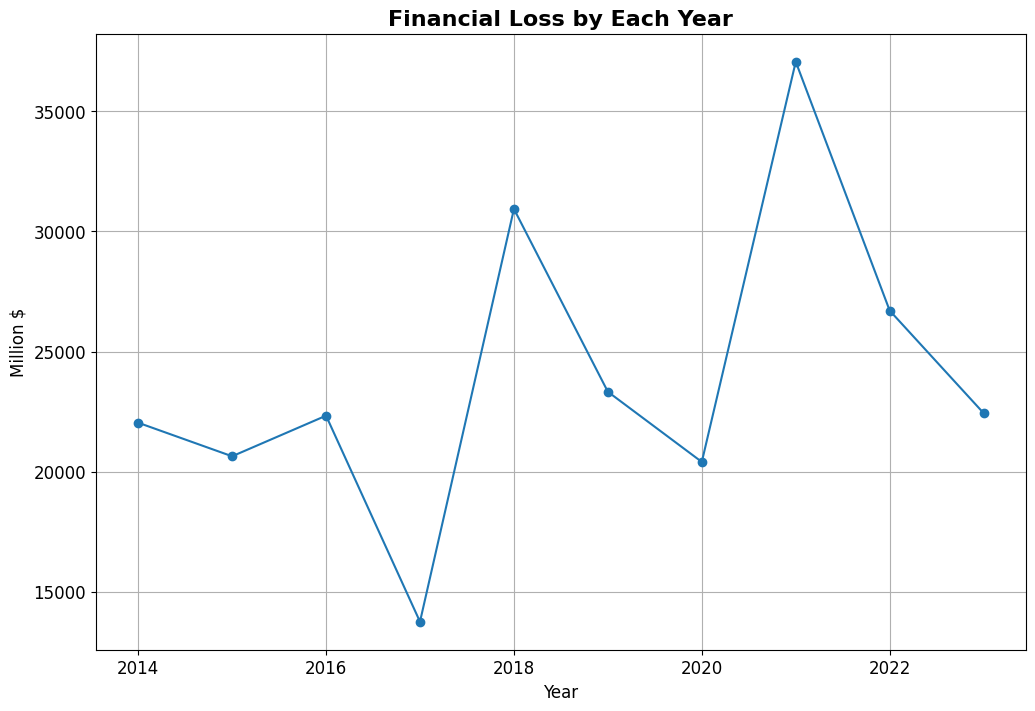

In [38]:
# The total financial damage by each year
plt.figure(figsize = (12,8))
total_sum = df.groupby('Year').agg(sum = ('Financial_Loss', 'sum')).reset_index()
plt.plot(total_sum['Year'], total_sum['sum'], marker = 'o')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel("Year", fontsize = 12)
plt.ylabel("Million $", fontsize = 12)
plt.title("Financial Loss by Each Year", fontsize = 16, weight = 'bold')
plt.grid()
plt.show()

<span style="font-size: 20px;">We see that the total finacial loss by each year doesn't have a clear trend. The financial loss in the later years seems to be a little bit higher but that's because we couldn't account for the inflation.</span>

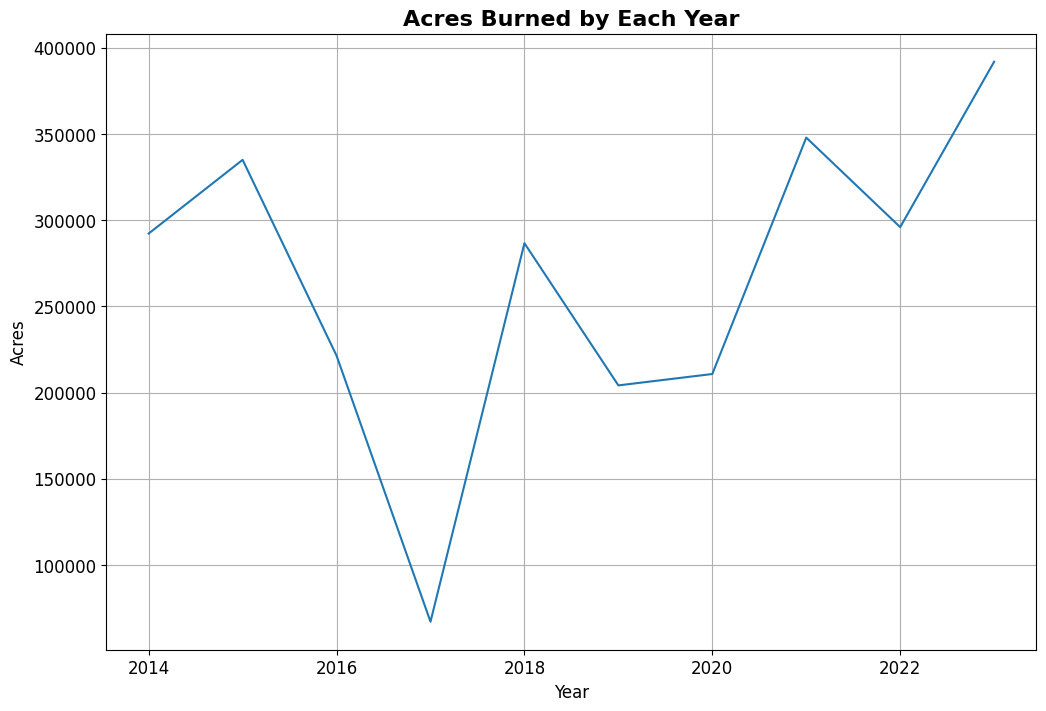

In [39]:
# The acres burned by wildfires each year
plt.figure(figsize = (12,8))
total_area = df.groupby('Year').agg(sum = ('Area_Burned', 'sum')).reset_index()
plt.plot(total_area['Year'], total_area['sum'])
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel("Year", fontsize = 12)
plt.ylabel("Acres", fontsize = 12)
plt.title("Acres Burned by Each Year", fontsize = 16, weight = 'bold')
plt.grid()
plt.show()

<span style="font-size: 20px;">We that there is an increase in the amount of acres destroyed in the recent years. However, the variation in all those years are quite large. Therefore, we can be sure if it's a clear trend that the area affected is increasing by year or not. To answer this question, we will need more data.</span>

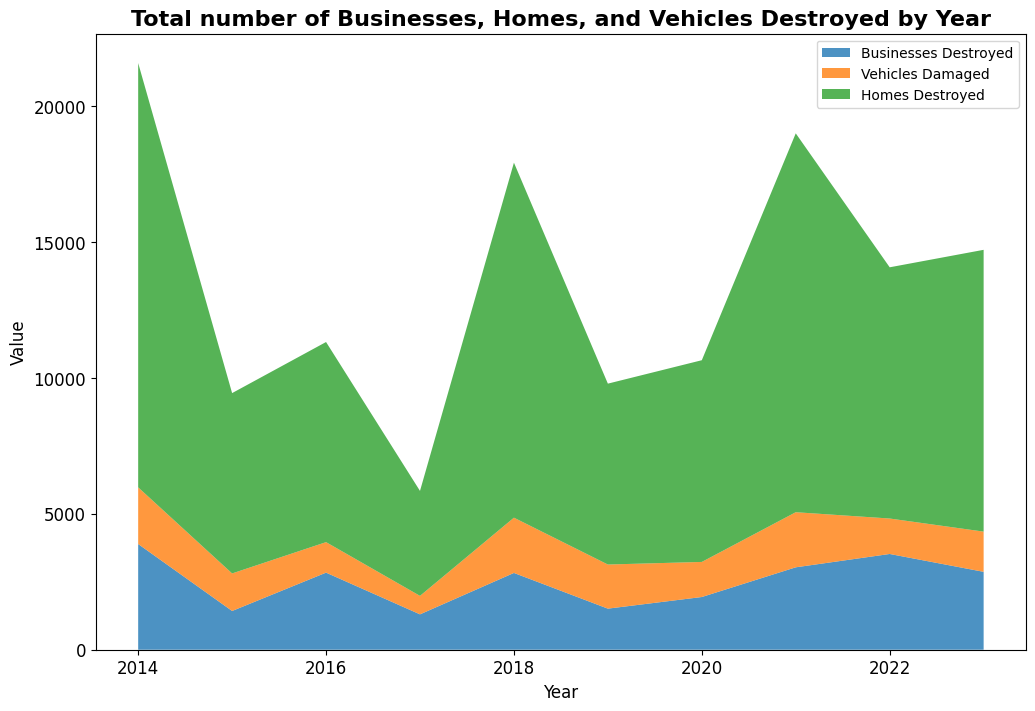

In [40]:
plt.figure(figsize = (12,8))
total_damaged = df.groupby('Year')[["Businesses_Destroyed", "Vehicles_Damaged", "Homes_Destroyed"]].sum().reset_index()
plt.stackplot(
    total_damaged['Year'],
    total_damaged['Businesses_Destroyed'],
    total_damaged['Vehicles_Damaged'],
    total_damaged['Homes_Destroyed'],
    labels=['Businesses Destroyed', 'Vehicles Damaged', 'Homes Destroyed'],
    alpha=0.8
)
plt.title("Total number of Businesses, Homes, and Vehicles Destroyed by Year", fontsize = 16, weight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel("Year", fontsize = 12)
plt.ylabel("Value", fontsize = 12)
plt.legend()
plt.show()

<span style="font-size: 20px;">We see that the number of houses, businesses, vehicles damaged all peaked in 2014. Then they took a sharp decrease and all fluctuates wildly. We see that the number of houses fluctuated the most but it's also because the number of houses destroyed are higher than 2 variables by a wide margin.</span>

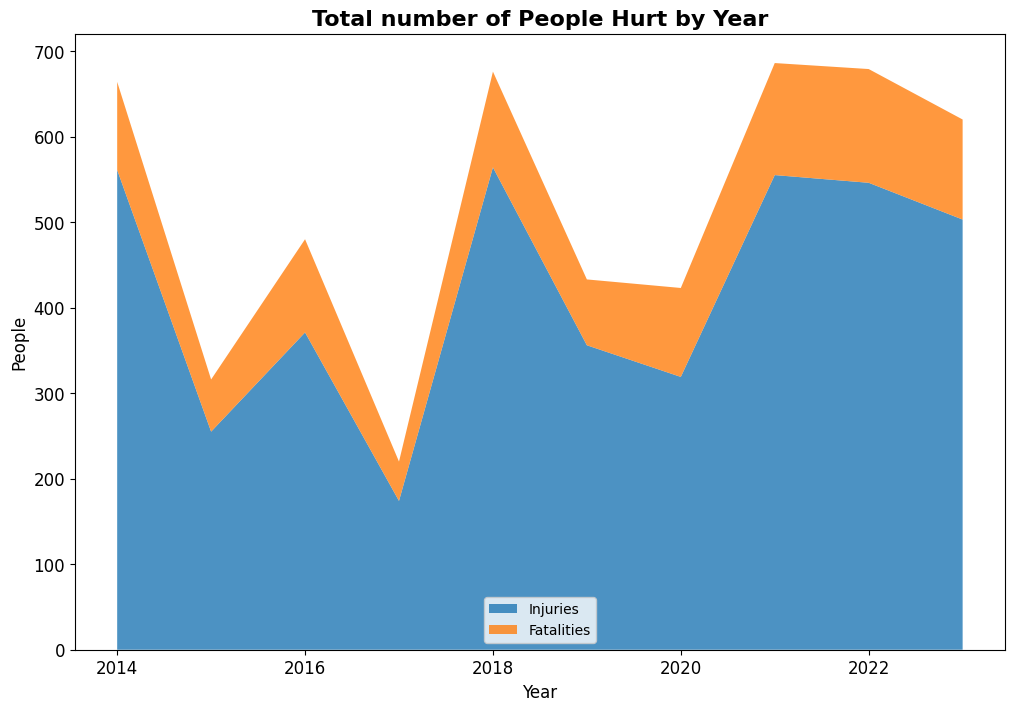

In [41]:
plt.figure(figsize = (12,8))
total_people = df.groupby('Year')[["Injuries", "Fatalities"]].sum().reset_index()
plt.stackplot(
    total_people['Year'],
    total_people['Injuries'],
    total_people['Fatalities'],
    labels=['Injuries', 'Fatalities'],
    alpha=0.8
)
plt.title("Total number of People Hurt by Year", fontsize = 16, weight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel("Year", fontsize = 12)
plt.ylabel("People", fontsize = 12)
plt.legend()
plt.show()

<span style="font-size: 20px;">We see that over severall years, the number of people that are injured by wildfires oscilliates around 400, and the number of peole who died are around 100. This showed the catastrophic of wildfires on peope's lives. Thankfully, there is no clear trend showing that these numbers are increasing.</span>

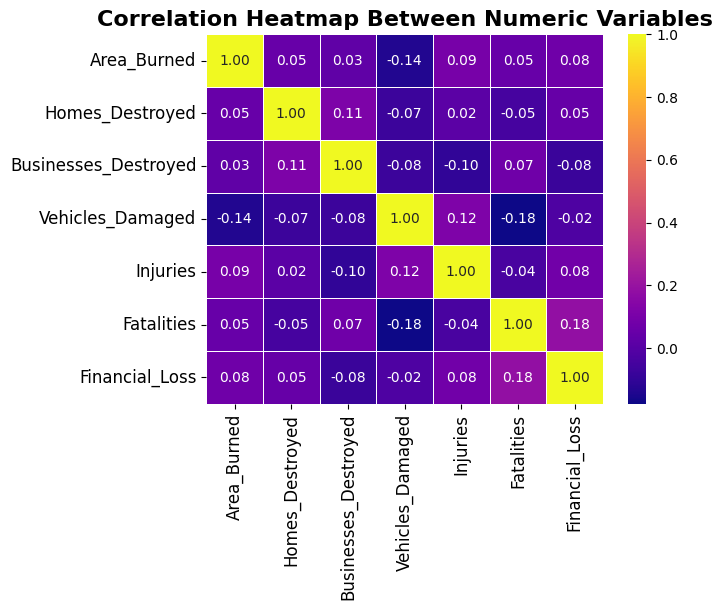

In [42]:
# Finding the correlation coefficients between variables
variables = ['Area_Burned', 'Homes_Destroyed', 'Businesses_Destroyed', 'Vehicles_Damaged', 'Injuries', 'Fatalities', 'Financial_Loss']
corr = df[variables].corr()
sns.heatmap(corr, annot= True, cmap = 'plasma', fmt = ".2f", linewidths= .5)
plt.title("Correlation Heatmap Between Numeric Variables", fontsize = 16, weight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.show()

<span style="font-size: 20px;">We can see that in the correlation heatmap, even though we have a lot of variables, the variables are not really correlated. The highest absolute coefficient is 0.18, between fatalities and vehicles and between fatalities and financial loss.</span> 

<span style="font-size: 20px;">Because of the low correlations we shouldn't use Principal Component Analysis on these variables as we would lose interpretability. Instead, we will try to use K-Means Clustering ont the original variables.</span>

## **Clustering Analysis**

<span style="font-size: 20px;">We decide to use K-Means method to cluster the fires that have the same characterisitics together. After that, we would see which counties are more likely to experience severly destructive fire.</span>

<span style="font-size: 20px;">We scale our data by using StandardScaler. After scaling, we would have the data with mean for each column equals 1 and standard deviation equals 0.</span>

In [43]:
X = df[["Area_Burned", "Financial_Loss", "Vehicles_Damaged", 
        "Homes_Destroyed", "Businesses_Destroyed", "Fatalities", 
        "Injuries"]]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


<span style="font-size: 20px;">We want to find the optimal number amount of clusters. In this project, we will use the elbow method. The elbow method will calculate the sum of squared distances for different numbers of clusters. Then we will pick the number of cluster where the Within-Cluster Sum of Squares (WCSS) decreases sharply.</span>

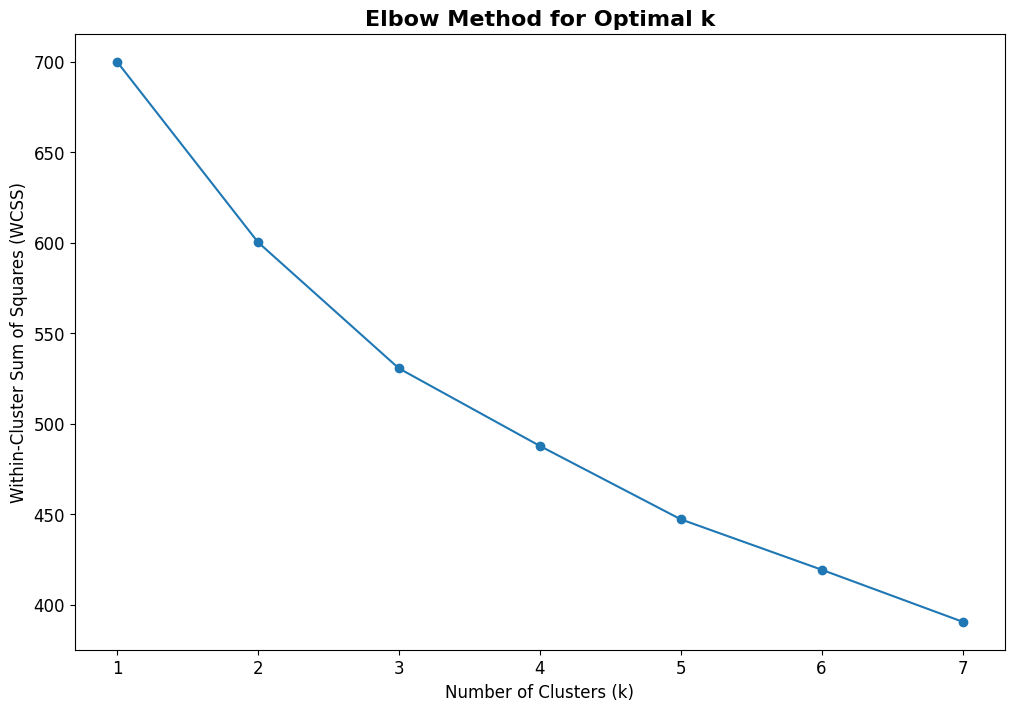

In [44]:
wcss = []

for k in range(1, 8):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(12, 8))
plt.plot(range(1, 8), wcss, marker='o')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel("Number of Clusters (k)", fontsize = 12)
plt.ylabel("Within-Cluster Sum of Squares (WCSS)", fontsize = 12)
plt.title("Elbow Method for Optimal k", fontsize = 16, weight = 'bold')
plt.show()

<span style="font-size: 20px;">We see that when the number of clusters increase from 2 to 3, WCSS took a sharp decline. However, moving from 3 onwards, the slope of decrease is not as large as the previous one. Therefore, the most optimal number of clusters is 3.</span>

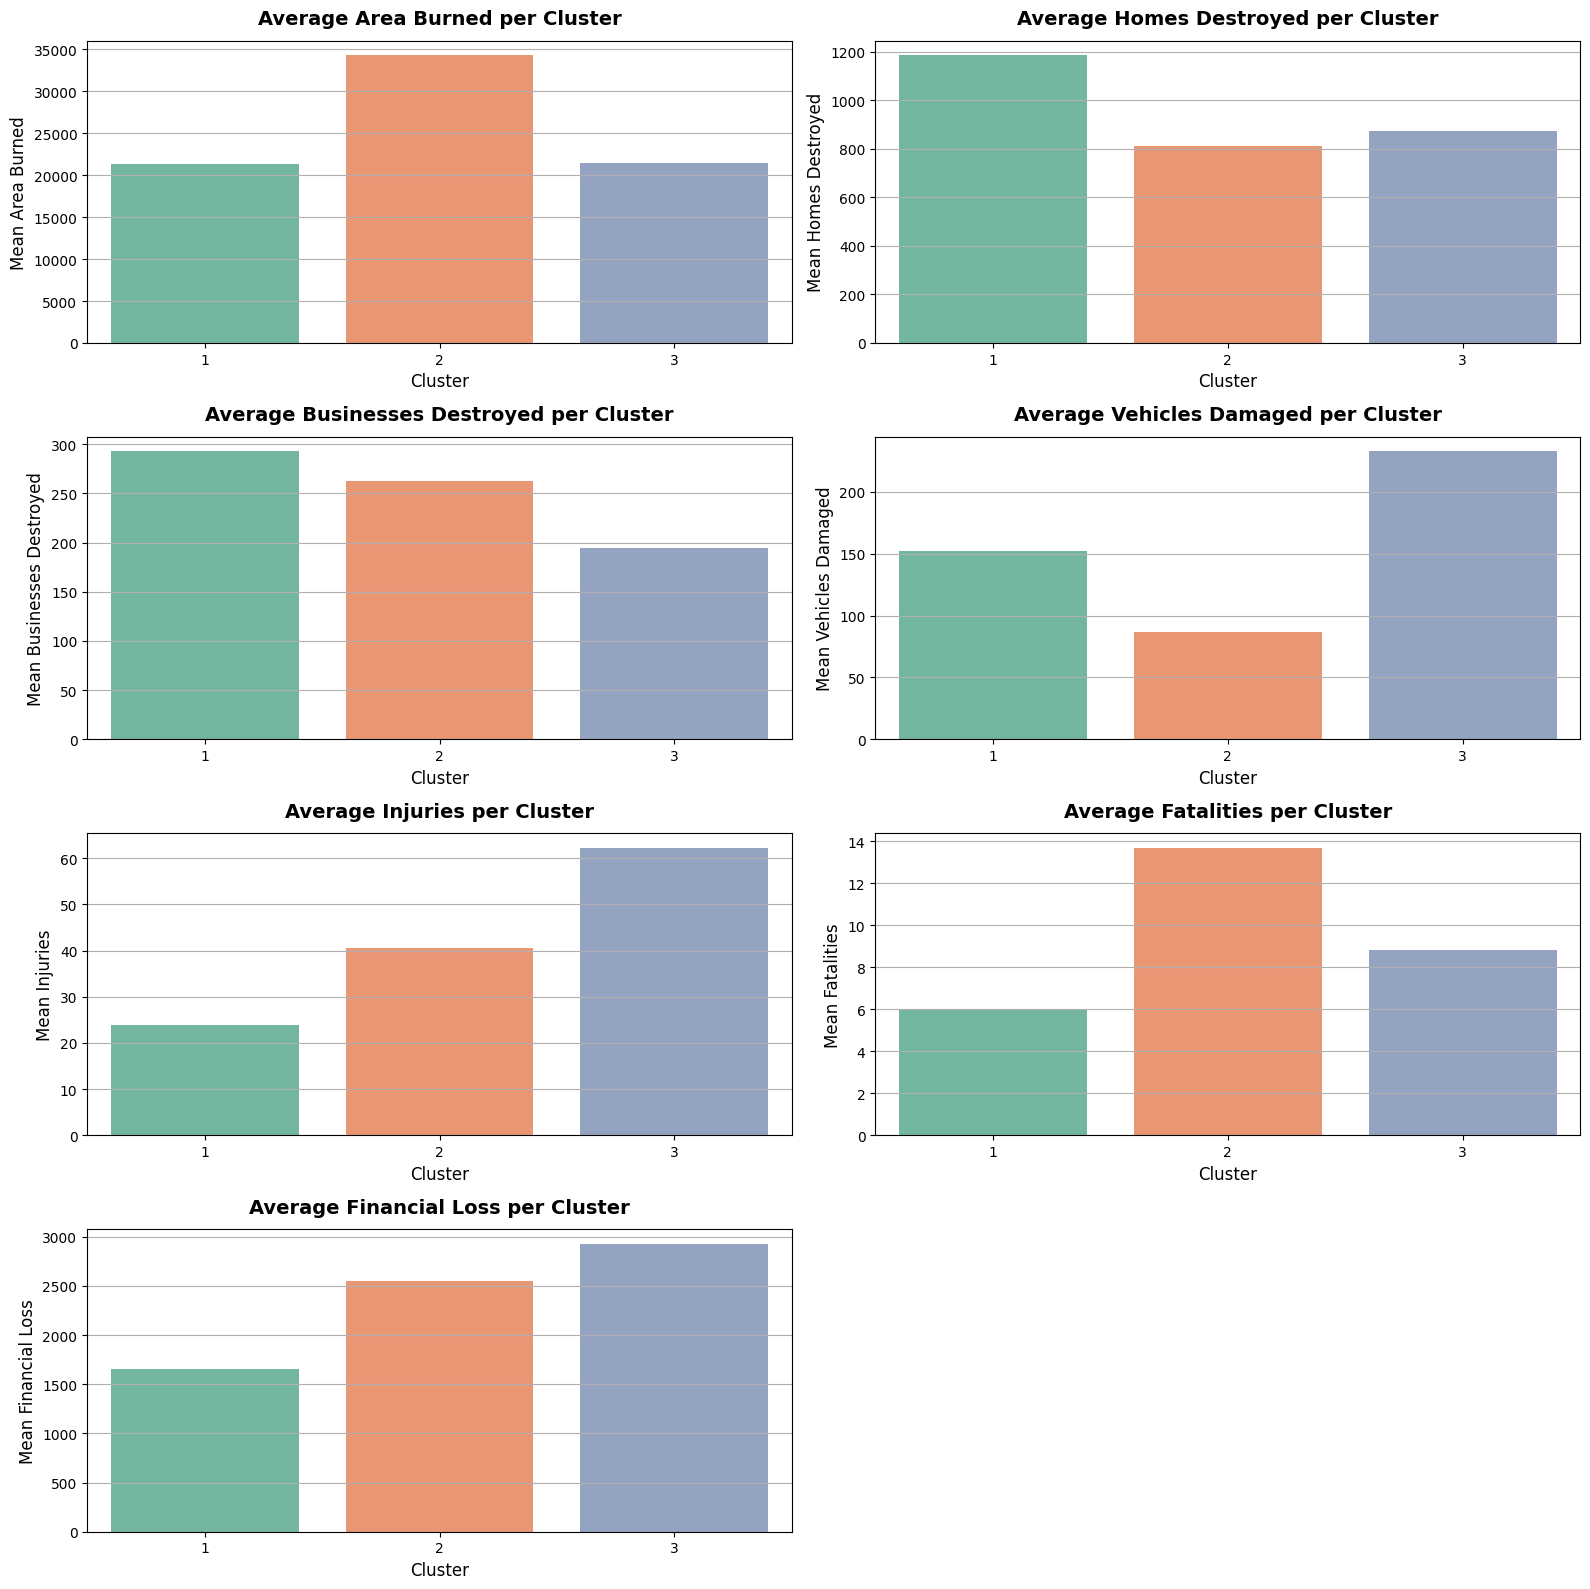

In [45]:
kmeans = KMeans(n_clusters=3, random_state=42)
df["Cluster"] = kmeans.fit_predict(X_scaled)+1
columns = df.select_dtypes(include = np.number).drop(['Year', 'Month', 'Cluster'], axis = 1).columns
n_cols = 2
n_rows = (len(columns) + 1) // n_cols  
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
axes = axes.flatten()
for i, column in enumerate(columns):
    df_plot = df.groupby('Cluster')[column].mean()
    sns.barplot(x=df_plot.index, y=df_plot.values, palette= 'Set2',
                hue = df_plot.index, ax=axes[i], legend = False)
    axes[i].set_title(f"Average {column.replace('_',' ').title()} per Cluster", 
                      fontsize=14, weight="bold", pad=12)
    axes[i].set_xlabel("Cluster", fontsize=12)
    axes[i].set_ylabel(f"Mean {column.replace('_',' ').title()}", fontsize=12)
    axes[i].grid(axis="y")
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

<span style="font-size: 20px;">Based on the plots, we see that Cluster 1 has the highest mean in homes destroyed and businesses burned. Cluster 1 is a group of wildfires that has greatly detrimental effect on real estate. 

<span style="font-size: 20px;">For Cluster 2, the average fatalities and area burned are significantly higher than that of Cluster 1 and 3. This cluster measures the spreadness of wildfires and its effect on humna. This cluster might be the most important to concern because it has a huge impact on communities and human lives.

<span style="font-size: 20px;">Finally, the Cluster 3 has a very high average financial loss, injuries, and vehicles damaged compared to other clusters. This cluster might be very useful for insurance companies looking to predict which area will have a higher amount of claims if wildfires happened.

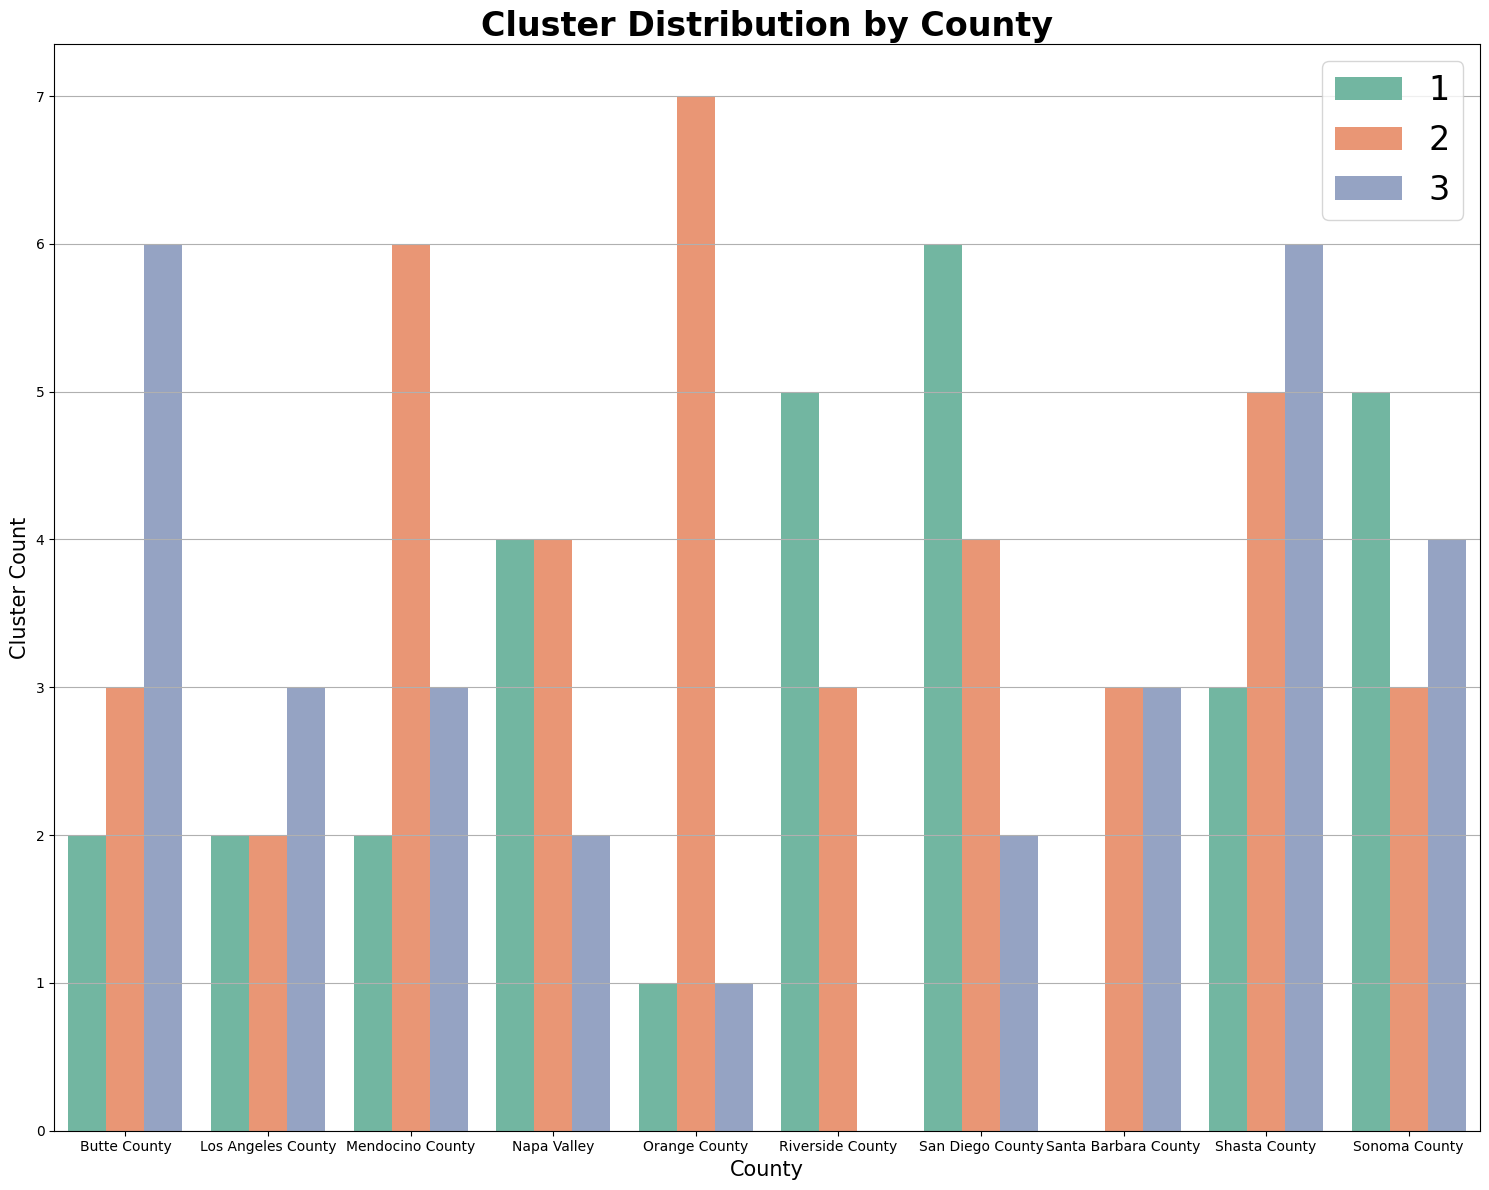

In [46]:
county_cluster_counts = df.groupby(["Location", "Cluster"]).agg(Count = ("Cluster", "count")).reset_index()
plt.figure(figsize = (15,12))
sns.barplot(data = county_cluster_counts, x = "Location", y = "Count", hue = "Cluster", palette= "Set2")
plt.xlabel("County", fontsize = 15)
plt.ylabel("Cluster Count", fontsize = 15)
plt.title("Cluster Distribution by County", fontsize = 24, weight = 'bold')
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.legend(fontsize = 24)
plt.tight_layout()
plt.grid(axis='y')
plt.show()

<span style="font-size: 20px;">The plot here shows how many each type of cluster does a county have:

<span style="font-size: 20px;"> - Butte County has the highest number of Cluster 3, following with 3 in Cluster 2 and 2 in Cluster 1. This means that Butte is at a higher risk to experience fires that is financially destructive, injures more people and vehicles. Luckily, the county has a very low number of Cluster 1 and 2, indicates that the wildfires happened there don't tend to destroy more valuable real estate or kill people.

<span style="font-size: 20px;"> - Los Angeles has the roughly equal number amount of each type of clusters. Los Angeles' wildfires are really unpredictable because it's hard to know which properties would be affected. 

<span style="font-size: 20px;"> - Mendocino County has the highest number for Cluster 2 (6). The wildfires in Mendocino are more likely to widespread and take many people lives. Therefore, government should allocate more money and resources to prevent fire in Mendociono as it's more destructive human and environment-wise. Despite the severe impact on environment and people, this county has a relative low number of fires in Cluster 1 and Cluster 3, demonstrating the fires didn't affect a lot of high-value properties.

<span style="font-size: 20px;"> - Nepa Valley also has a high number in Cluster 2. This county also needs to be strictly monitored to prevent the catastrophic consquences on the community. One interesting is Nepa also has the same number of fires in Cluster 1. The fires here not only threatening the lives of the residents but also affecting a lot of households.

<span style="font-size: 20px;"> - Orange County has the highest number of fires in Cluster 2 compared to other counties. 

## **Conclusion**